##Preparation

In [29]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [31]:
# load data
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo/Raw Data/heart_disease_health_indicators_BRFSS2015.csv')
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

##Pre-processing

In [33]:
# check for null values
df.isna().sum()

HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

There are no null values to impute.

In [34]:
# check for duplicates
df.duplicated().any()

True

There are duplicated values within our dataset. We will drop these duplicates in the following code.

In [35]:
# drop duplicates
df.drop_duplicates(inplace = True)

In [36]:
# confirm no duplicates
df.duplicated().any()

False

##Model Preparation

In [37]:
# check target balance
df['HeartDiseaseorAttack'].value_counts(normalize = 'true')

0.0    0.896784
1.0    0.103216
Name: HeartDiseaseorAttack, dtype: float64

Our target is very imbalanced. After our train/test split, we will address this issue using a random undersampler.

In [38]:
# define features and target
X = df.drop(columns = 'HeartDiseaseorAttack')
y = df['HeartDiseaseorAttack']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [39]:
# instantiate scaler
scaler = StandardScaler()

# apply scaler to features
train_scale = scaler.fit_transform(X_train)
test_scale = scaler.transform(X_test)

The following code will use RandomUnderSampler to address our class imbalance.

In [40]:
# import imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

# utilize RandomUnderSampler to build usable training data
rus = RandomUnderSampler(random_state = 42, replacement = True)
X_rus, y_rus = rus.fit_resample(train_scale, y_train)

In [41]:
print('Original Dataset Shape:\n', y_train.value_counts())
print('\nResampled Dataset Shape:\n', y_rus.value_counts())

Original Dataset Shape:
 0.0    154552
1.0     17783
Name: HeartDiseaseorAttack, dtype: int64

Resampled Dataset Shape:
 0.0    17783
1.0    17783
Name: HeartDiseaseorAttack, dtype: int64


We see above, that we now have a training dataset of perfectly balanced data.

##Model Development

In [42]:
# create function to evaluate model
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

In [43]:
# get shape of training data
X_train.shape

(172335, 21)

In [48]:
# Create model
model1 = Sequential()

# add hidden layers
model1.add(Dense(20, activation = 'relu', input_dim = X_train.shape[1]))
model1.add(Dropout(.1))
model1.add(Dense(10, activation = 'relu'))
model1.add(Dropout(.1))
model1.add(Dense(1, activation = 'sigmoid'))

In [49]:
# compile model
model1.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

In [50]:
# fit model
early_stopping = EarlyStopping(patience = 10)
history1 = model1.fit(X_rus, y_rus,
                    validation_data = (test_scale, y_test),
                    epochs = 250,
                    callbacks = [early_stopping])

Epoch 1/250
1112/1112 [==============================] - 5s 4ms/step - loss: 0.5388 - acc: 0.7256 - val_loss: 0.5057 - val_acc: 0.7073
Epoch 2/250
1112/1112 [==============================] - 5s 4ms/step - loss: 0.5109 - acc: 0.7519 - val_loss: 0.5022 - val_acc: 0.7164
Epoch 3/250
1112/1112 [==============================] - 5s 4ms/step - loss: 0.5064 - acc: 0.7555 - val_loss: 0.5218 - val_acc: 0.7097
Epoch 4/250
1112/1112 [==============================] - 5s 4ms/step - loss: 0.5038 - acc: 0.7568 - val_loss: 0.5190 - val_acc: 0.7145
Epoch 5/250
1112/1112 [==============================] - 4s 4ms/step - loss: 0.5040 - acc: 0.7589 - val_loss: 0.4784 - val_acc: 0.7306
Epoch 6/250
1112/1112 [==============================] - 5s 4ms/step - loss: 0.5008 - acc: 0.7593 - val_loss: 0.4983 - val_acc: 0.7209
Epoch 7/250
1112/1112 [==============================] - 4s 4ms/step - loss: 0.5008 - acc: 0.7595 - val_loss: 0.4964 - val_acc: 0.7196
Epoch 8/250
1112/1112 [==============================] 

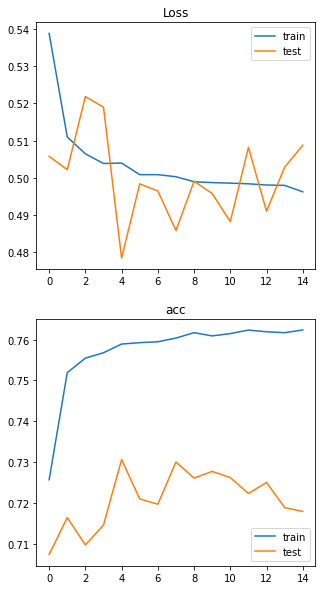

In [51]:
plot_history(history1, 'acc')